In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    r2_score,
    mean_squared_error,
)

Set random seed for reproducibility


In [57]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [58]:
data_path = "./data/"
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

Using device: mps


# Load and prepare data

Only data before 2023 is available in fbi dataset, so we use 2022-2023 for testing


In [59]:
data = pd.read_csv(f"{data_path}rnn_data.csv")
data = data[data["location_id"] != 99]
data_gen = pd.read_csv(f"{data_path}rnn_data_AL.csv")
data_gen = data_gen[data_gen["Year"].isin([2022, 2023])]
seq_len = 12
for e in data["location_id"].unique():
    if e not in data_gen["location_id"].unique():
        print(f"Location ID: {e}")

# Create Mapping

Use mapping for location and time so we can map it back after training.


In [60]:
min_year = np.min(data["Year"].unique())
n_times = data["time_id"].nunique()
n_locations = data["location_id"].nunique()
n_times_gen = data_gen["time_id"].nunique()
n_locations_gen = data_gen["location_id"].nunique()
location2idx = {location: i for i, location in enumerate(data["location_id"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_id"].unique())}
location2idx_gen = {
    location: i for i, location in enumerate(data_gen["location_id"].unique())
}
time2idx_gen = {time: i for i, time in enumerate(data_gen["time_id"].unique())}
data["location_idx"] = data["location_id"].map(location2idx)
data["time_idx"] = data["time_id"].map(time2idx)
data_gen["location_idx"] = data_gen["location_id"].map(location2idx_gen)
data_gen["time_idx"] = data_gen["time_id"].map(time2idx_gen)
data.head(5)

,location_name,location_id,Year,Month,crime_count,arrest,domestic,weekday,weekend,morning,...,morning_rate,afternoon_rate,evening_rate,night_rate,sin_month,cos_month,time_id,crime_pct_change,location_idx,time_idx
0,Abandoned/Condemned Structure,1,2018,1,20,7,1,15,5,8,...,0.400000,0.300000,0.200000,0.100000,0.000000,1.000000e+00,24217,-0.166667,0,0
1,Abandoned/Condemned Structure,1,2018,2,20,7,0,18,2,11,...,0.550000,0.200000,0.100000,0.150000,0.500000,8.660254e-01,24218,0.000000,0,1
2,Abandoned/Condemned Structure,1,2018,3,24,12,1,14,10,10,...,0.416667,0.500000,0.083333,0.000000,0.866025,5.000000e-01,24219,0.200000,0,2
3,Abandoned/Condemned Structure,1,2018,4,27,10,3,17,10,8,...,0.296296,0.592593,0.037037,0.074074,1.000000,6.123234e-17,24220,0.125000,0,3
4,Abandoned/Condemned Structure,1,2018,5,36,20,2,30,6,11,...,0.305556,0.305556,0.277778,0.111111,0.866025,-5.000000e-01,24221,0.333333,0,4


# Features used

Features required for LSTM are "crime_count", "crime_pct_change", "Year", "Month", "arrest_rate", "domestic_rate", "morning_rate", "evening_rate", "afternoon_rate", "night_rate", "num_days", "holiday_num", "sin_month", "cos_month".

LSTM does not require previous data for training in each row since we use sliding window with sequence length equal to 12.


In [61]:
features = [
    "crime_count",
    "crime_pct_change",
    "Year",
    "Month",
    "morning_rate",
    "evening_rate",
    "afternoon_rate",
    "night_rate",
    "num_days",
    "holiday_num",
    "sin_month",
    "cos_month",
]
n_features = len(features)
pivot_df = data.pivot(
    index="time_idx",
    columns="location_idx",
    values=features,
)
pivot_df_gen = data_gen.pivot(
    index="time_idx",
    columns="location_idx",
    values=features,
)
pivot_df = pivot_df.fillna(0)
train_size = int((len(pivot_df) - seq_len) - 12)
print(f"train_size: {train_size}")
# time_features = pd.DataFrame(index=pivot_df.index)
# time_features["holiday_num"] = data.groupby("time_idx")["holiday_count"].first()
# time_features["sin_month"] = data.groupby("time_idx")["sin_month"].first()
# time_features["cos_month"] = data.groupby("time_idx")["cos_month"].first()
pivot_df.head(5)

train_size: 60


crime_count                                                     \
location_idx          0      1     2     3     4      5      6    7      8    
time_idx                                                                      
0                   20.0  518.0  18.0  49.0  20.0  115.0  189.0  1.0  143.0   
1                   20.0  504.0  29.0  58.0  16.0  108.0  179.0  1.0  139.0   
2                   24.0  566.0  23.0  33.0  26.0  123.0  228.0  0.0  149.0   
3                   27.0  563.0  26.0  40.0  20.0  118.0  246.0  0.0  170.0   
4                   36.0  628.0  31.0  50.0  41.0  133.0  215.0  0.0  165.0   

                    ...     cos_month                                   \
location_idx    9   ...            21            22   23            24   
time_idx            ...                                                  
0             28.0  ...  1.000000e+00  0.000000e+00  0.0  1.000000e+00   
1             21.0  ...  8.660254e-01  8.660254e-01  0.0  8.660254e-01   
2             27.0  ...  5.000000e-01  5.000000e-01  0.0  5.000000e-01   
3             34.0  ...  6.123234e-17  6.123234e-17  0.0  6.123234e-17   
4             36.0  ... -5.000000e-01 -5.000000e-01  0.0 -5.000000e-01   

                                                                      \
location_idx            25            26            27            28   
time_idx                                                               
0             1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1             8.660254e-01  8.660254e-01  8.660254e-01  8.660254e-01   
2             5.000000e-01  5.000000e-01  5.000000e-01  5.000000e-01   
3             6.123234e-17  6.123234e-17  6.123234e-17  6.123234e-17   
4            -5.000000e-01 -5.000000e-01 -5.000000e-01 -5.000000e-01   

                                          
location_idx            29            30  
time_idx                                  
0             1.000000e+00  1.000000e+00  
1             8.660254e-01  8.660254e-01  
2             5.000000e-01  5.000000e-01  
3             6.123234e-17  6.123234e-17  
4            -5.000000e-01 -5.000000e-01  

[5 rows x 372 columns]

# Apply scaler.


In [62]:
def scale_by_feature_type(pivot_df, train_size, seq_len):
    scaled_df = pivot_df.copy()
    feature_types = pivot_df.columns.get_level_values(0).unique()
    scaler_ls = []
    for feature in feature_types:
        feature_cols = [col for col in pivot_df.columns if col[0] == feature]
        scaler = MinMaxScaler()
        feature_data = pivot_df[feature_cols]
        train_data = feature_data.iloc[: train_size + seq_len]
        scaler.fit(train_data)
        scaled_df[feature_cols] = scaler.transform(feature_data)
        scaler_ls.append(scaler)
    return scaled_df, scaler_ls


scaled_df, scaler_ls = scale_by_feature_type(pivot_df, train_size, seq_len)
scaled_df_gen, scaler_ls_gen = scale_by_feature_type(pivot_df_gen, 0, seq_len)

## Sliding Window Training/Testing Configuration

### Data Structure

- **Dataset**: Crime count data across 32 locations from 2019-2024 (monthly)
- **Time periods**: 72 months (6 years × 12 months)
- **Total samples**: 2,304 (32 locations × 72 time periods)

### Training Configuration

- **Window size**: 12 (using previous 12 months to predict next month)

### Tensor Dimensions

| Tensor     | Shape          | Description                                                |
| ---------- | -------------- | ---------------------------------------------------------- |
| `X_seq`    | (2304, 12, 14) | Input sequences with 12 time steps and 14 features         |
| `y`        | (2304,)        | Target values (crime count for next month)                 |
| `loc_idx`  | (2304,)        | Location indices for mapping predictions back to locations |
| `time_idx` | (2304,)        | Time indices for mapping predictions back to timestamps    |


In [63]:
def create_sequences(feat_df, seq_length=12):
    X_seq = []
    y_vals = []
    loc_idx = []
    time_idx = []
    T = feat_df.shape[0]
    locations = feat_df.columns.get_level_values(1).unique()
    crime_feature = feat_df.columns.get_level_values(0)[
        0
    ]  # Assuming 'crime_count' is the first feature type
    for location in locations:
        location_data = feat_df.xs(location, axis=1, level=1)

        # Create sliding windows
        for i in range(T - seq_length):
            # Extract feature window for all features
            feature_window = location_data.iloc[
                i : i + seq_length
            ].values  # shape (seq_length, n_features)
            y_val = feat_df[(crime_feature, location)].iloc[i + seq_length]
            X_seq.append(feature_window)
            y_vals.append(y_val)
            loc_idx.append(location)
            time_idx.append(i)
    X_seq = np.array(X_seq)  # shape => (n_locations * n_times, seq_length, n_features)
    y_vals = np.array(y_vals)  # shape => (n_locations * n_times,)
    loc_idx = np.array(loc_idx)  # shape => (n_locations * n_times,)
    time_idx = np.array(time_idx)  # shape => (n_locations * n_times,)
    return X_seq, y_vals, loc_idx, time_idx


X_seq, y, loc_idx, time_idx = create_sequences(scaled_df, seq_length=seq_len)
X_seq_gen, y_gen, loc_idx_gen, time_idx_gen = create_sequences(
    scaled_df_gen, seq_length=seq_len
)

print("X_seq shape:", X_seq.shape)  # (n_locations * n_times, seq_length, n_features)
print("y shape:", y.shape)  # (n_locations * n_times,)
print("loc_idx shape:", loc_idx.shape)  # (n_locations * n_times,)
print("time_idx shape:", time_idx.shape)  # (n_locations * n_times,)
print("\nGeneralization test data:")
print(
    "X_seq_gen shape:", X_seq_gen.shape
)  # (n_locations * n_times, seq_length, n_features)
print("y_gen shape:", y_gen.shape)  # (n_locations * n_times,)
print("loc_idx_gen shape:", loc_idx_gen.shape)  # (n_locations * n_times,)
print("time_idx_gen shape:", time_idx_gen.shape)  # (n_locations * n_times,)

X_seq shape: (2232, 12, 12)
y shape: (2232,)
loc_idx shape: (2232,)
time_idx shape: (2232,)

Generalization test data:
X_seq_gen shape: (372, 12, 12)
y_gen shape: (372,)
loc_idx_gen shape: (372,)
time_idx_gen shape: (372,)


In [64]:
train_mask = time_idx < train_size
test_mask = time_idx >= train_size

X_train = X_seq[train_mask]
y_train = y[train_mask]
loc_train = loc_idx[train_mask]
time_train = time_idx[train_mask]

X_test = X_seq[test_mask]
y_test = y[test_mask]
loc_test = loc_idx[test_mask]
time_test = time_idx[test_mask]


print("Train shapes:", X_train.shape, y_train.shape, loc_train.shape, time_train.shape)
print("Test shapes:", X_test.shape, y_test.shape, loc_test.shape, time_test.shape)

Train shapes: (1860, 12, 12) (1860,) (1860,) (1860,)
Test shapes: (372, 12, 12) (372,) (372,) (372,)


In [65]:
class CrimeDataset(Dataset):
    def __init__(self, X, y, loc_idx, time_idx):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx
        self.time_idx = time_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        time_idx = torch.tensor(self.time_idx[idx], dtype=torch.long)
        return X, y, loc_idx, time_idx

In [66]:
num_size = n_features
cat_size = n_locations
batch_size = 32
hidden_size = 128
num_layers = 3
embed_dim = 16
output_size = 1
num_epochs = 100
dropout = 0.5

In [67]:
train_dataset = CrimeDataset(X_train, y_train, loc_train, time_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CrimeDataset(X_test, y_test, loc_test, time_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
gen_dataset = CrimeDataset(X_seq_gen, y_gen, loc_idx_gen, time_idx_gen)
gen_loader = DataLoader(gen_dataset, batch_size=batch_size, shuffle=False)

In [68]:
for X_batch, y_batch, loc_batch, time_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    print(f"loc_batch shape: {loc_batch.shape}")
    print(f"time_batch shape: {time_batch.shape}")
    break

X_batch shape: torch.Size([32, 12, 12])
y_batch shape: torch.Size([32])
loc_batch shape: torch.Size([32])
time_batch shape: torch.Size([32])


In [69]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, X, loc, h_0, c_0):
        """
        x: [batch_size, seq_len, n_feature]
        h_0, c_0: [num_layers, batch_size, hidden_size]
        output: [batch_size, n_location, output_size]
        """
        _, seq_len, _ = X.shape
        loc_embed = self.embedding(loc)
        loc_embed = loc_embed.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_input = torch.cat((X, loc_embed), dim=2)
        lstm_output, (h_n, c_n) = self.lstm(lstm_input, (h_0, c_0))
        last_output = lstm_output[:, -1, :]
        fc_out = self.fc1(last_output)
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        fc_out = self.fc2(fc_out)  # [batch_size*n_location, output_size]
        return fc_out, (h_n, c_n)

In [70]:
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

CrimeLSTM(
  (embedding): Embedding(31, 16)
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define loss function and optimizer


In [71]:
criterion = nn.MSELoss()

Training function


In [72]:
# Validation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for X_batch, y_batch, loc_batch, _ in test_loader:
            X_batch, y_batch, loc_batch = (
                X_batch.to(device),
                y_batch.to(device),
                loc_batch.to(device),
            )
            curr_batch_size = X_batch.shape[0]
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.view(curr_batch_size)
            loss = criterion(score, y_batch)
            val_loss += loss.item()
            num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [73]:
start_time = time.time()
train_losses = []
val_losses = []
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # because we're monitoring loss
    factor=0.5,  # how much to reduce the LR
    patience=5,  # how many epochs to wait
    threshold=1e-4,  # min improvement to be considered
    cooldown=0,  # cooldown after reduction
    min_lr=1e-6,  # don’t go below this
)
best_val_loss = float("inf")
model_path = "./model/lstm_model_gen.pth"
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for X_batch, y_batch, loc_batch, _ in train_loader:
        optimizer.zero_grad()
        curr_batch_size = X_batch.shape[0]
        X_batch, y_batch, loc_batch = (
            X_batch.to(device),
            y_batch.to(device),
            loc_batch.to(device),
        )
        h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        score, (_, _) = model(X_batch, loc_batch, h, c)
        score = score.reshape(curr_batch_size)
        loss = criterion(score, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, LR: {scheduler.get_last_lr()[0]:.12f}"
    )
torch.save(model.state_dict(), model_path)
print(f"Model saved in {model_path}")

Epoch [1/100], Train Loss: 0.075357869118, Val Loss: 0.658982387511, LR: 0.001000000000
Epoch [2/100], Train Loss: 0.054955892612, Val Loss: 0.652751863003, LR: 0.001000000000
Epoch [3/100], Train Loss: 0.047449573464, Val Loss: 0.618107719968, LR: 0.001000000000
Epoch [4/100], Train Loss: 0.041941423948, Val Loss: 0.582148882172, LR: 0.001000000000
Epoch [5/100], Train Loss: 0.038778352772, Val Loss: 0.552101589041, LR: 0.001000000000
Epoch [6/100], Train Loss: 0.036275226907, Val Loss: 0.535498883498, LR: 0.001000000000
Epoch [7/100], Train Loss: 0.033957349468, Val Loss: 0.528500016352, LR: 0.001000000000
Epoch [8/100], Train Loss: 0.032703292493, Val Loss: 0.508969129839, LR: 0.001000000000
Epoch [9/100], Train Loss: 0.031975757946, Val Loss: 0.502653087256, LR: 0.001000000000
Epoch [10/100], Train Loss: 0.032100112193, Val Loss: 0.492384835069, LR: 0.001000000000
Epoch [11/100], Train Loss: 0.030266960404, Val Loss: 0.485028831948, LR: 0.001000000000
Epoch [12/100], Train Loss: 0.

Train the model


Plot training and validation loss


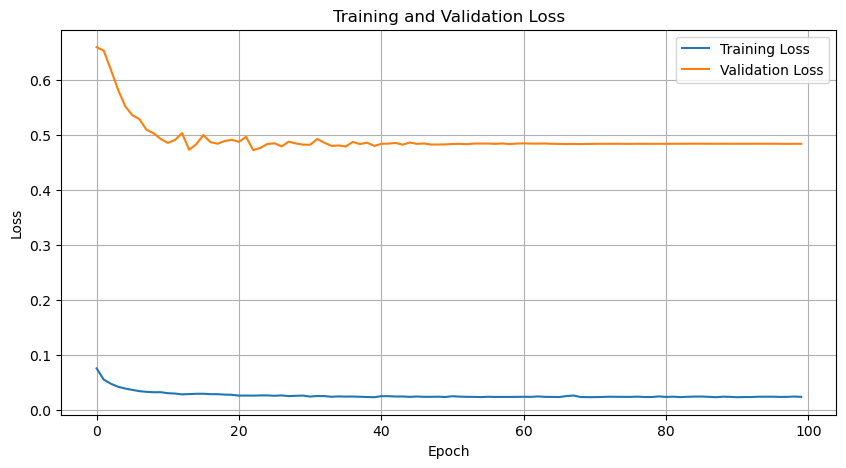

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("./figure/training_validation_loss_gen.pdf", format="pdf")
plt.show()

In [75]:
def predictions(model, loader):
    result = np.zeros(
        (
            len(loader.dataset) // n_locations,
            n_locations,
            2,
        )
    )

    def get_result(result, loader):
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch, loc_batch, time_batch) in enumerate(loader):
                curr_batch_size = X_batch.shape[0]
                X_batch, y_batch, loc_batch = (
                    X_batch.to(device),
                    y_batch.to(device),
                    loc_batch.to(device),
                )
                h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                score, (_, _) = model(X_batch, loc_batch, h, c)
                score = score.reshape(curr_batch_size)
                result[time_batch, loc_batch.cpu().numpy(), 0] = score.cpu().numpy()
                result[time_batch, loc_batch.cpu().numpy(), 1] = y_batch.cpu().numpy()

    get_result(result, loader)
    return result

In [76]:
pred_model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
pred_model.load_state_dict(torch.load(model_path))

/var/folders/sx/pmvfmfnd1yb2twxrjn65_p0m0000gn/T/ipykernel_70826/2887214277.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred_model.load_state_dict(torch.load(model_p

<All keys matched successfully>

In [77]:
result = predictions(model, gen_loader)
result_unscaled = np.zeros(result.shape)
result_unscaled[:, :, 0] = scaler_ls_gen[0].inverse_transform(result[:, :, 0])
result_unscaled[:, :, 1] = scaler_ls_gen[0].inverse_transform(result[:, :, 1])
result_unscaled = np.round(result_unscaled).astype(int)
result_df = data_gen.copy()
result_df["lstm_pred"] = np.nan
for i in range(len(result_unscaled)):
    for j in range(len(result_unscaled[i])):
        result_df.loc[
            (result_df["time_idx"] == i + seq_len) & (result_df["location_idx"] == j),
            "lstm_pred",
        ] = result_unscaled[i, j, 0]

In [78]:
result_df = result_df[result_df["time_idx"] > seq_len - 1]
result_df.to_csv("./data/lstm_predictions_gen.csv", index=False)

In [79]:
result_df[
    [
        "Year",
        "Month",
        "location_id",
        "location_name",
        "time_id",
        "time_idx",
        "location_idx",
        "crime_count",
        "lstm_pred",
    ]
].head(5)

,Year,Month,location_id,location_name,time_id,time_idx,location_idx,crime_count,lstm_pred
24,2023,1,1,Abandoned/Condemned Structure,24277,12,0,25,14.0
25,2023,2,1,Abandoned/Condemned Structure,24278,13,0,13,16.0
26,2023,3,1,Abandoned/Condemned Structure,24279,14,0,19,17.0
27,2023,4,1,Abandoned/Condemned Structure,24280,15,0,18,17.0
28,2023,5,1,Abandoned/Condemned Structure,24281,16,0,13,18.0


In [80]:
def weighted_mape(y_true, y_pred):
    """Calculate Weighted Mean Absolute Percentage Error"""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100


y_gen_true = result_df["crime_count"].values
y_gen_pred = result_df["lstm_pred"].values
mae_gen = mean_absolute_error(y_gen_true, y_gen_pred)
rmse_gen = root_mean_squared_error(y_gen_true, y_gen_pred)
r2_gen = r2_score(y_gen_true, y_gen_pred)
gen_mean_value = np.mean(y_gen_true)
wmae_gen = weighted_mape(y_gen_true, y_gen_pred)

print(
    f"MAE: {mae_gen:.4f}, RMSE: {rmse_gen:.4f}, R2: {r2_gen:.4f}, Normalized MAE Percentage: {wmae_gen:.4f}%"
)

MAE: 51.1022, RMSE: 143.8026, R2: 0.9932, Normalized MAE Percentage: 7.6764%


In [81]:
result_df[["location_id", "location_name"]]
idx2location = pd.Series(
    result_df["location_name"].unique(), index=result_df["location_idx"].unique()
).to_dict()

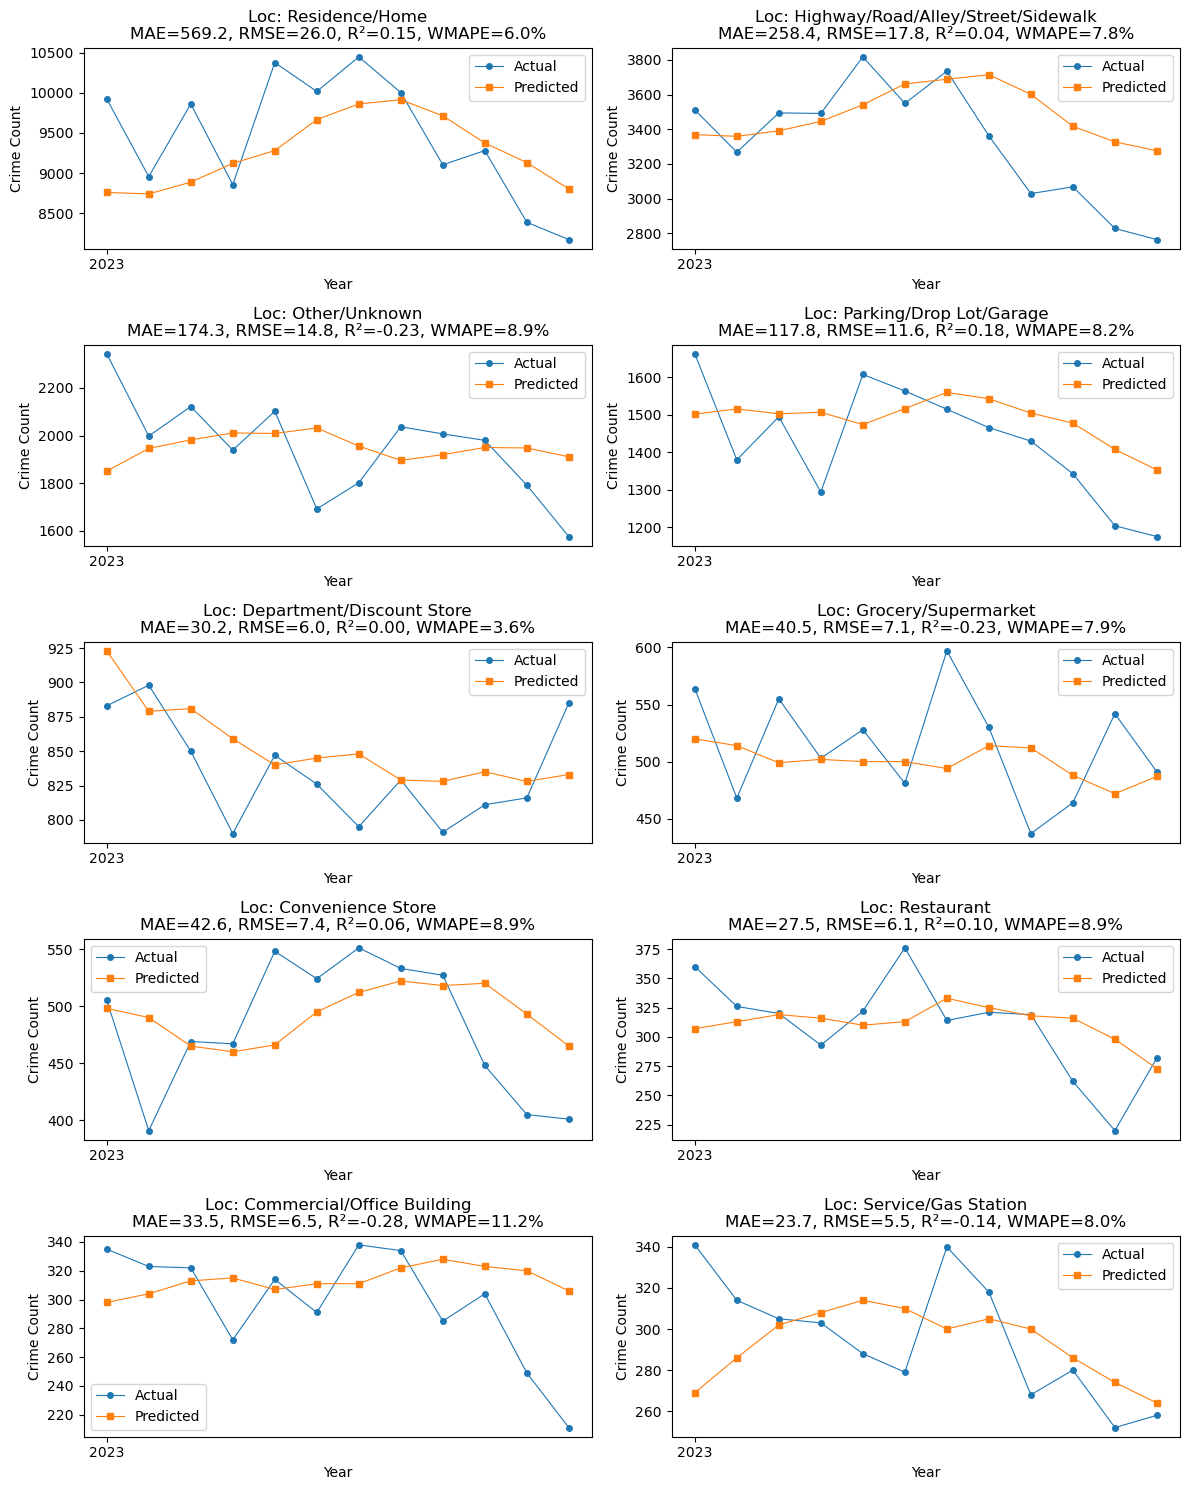

In [82]:
df = result_df.copy()
df.sort_values(["location_idx", "Year", "Month"], inplace=True)
total_by_loc = (
    df.groupby("location_idx")["crime_count"].sum().sort_values(ascending=False)
)
top_locations = total_by_loc.index[:10]
df_top = df[df["location_idx"].isin(top_locations)].copy()
df_top.sort_values(["location_idx", "Year", "Month"], inplace=True)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axes = axes.flatten()
for i, loc in enumerate(top_locations):
    df_loc = df_top[df_top["location_idx"] == loc].copy()
    df_loc.sort_values(["Year", "Month"], inplace=True)
    df_loc.reset_index(drop=True, inplace=True)  # reset index so x-axis is 0, 1, 2, ...
    x_vals = df_loc.index  # Each index represents one month
    actual = df_loc["crime_count"].values
    predicted = df_loc["lstm_pred"].values
    mae_val = mean_absolute_error(actual, predicted)
    rmse_val = np.sqrt(root_mean_squared_error(actual, predicted))
    r2_val = r2_score(actual, predicted)
    wmape = weighted_mape(actual, predicted)
    ax = axes[i]
    ax.plot(x_vals, actual, marker="o", markersize=4, linewidth=0.8, label="Actual")
    ax.plot(
        x_vals, predicted, marker="s", markersize=4, linewidth=0.8, label="Predicted"
    )
    ax.set_title(
        f"Loc: {idx2location[loc]}\nMAE={mae_val:.1f}, RMSE={rmse_val:.1f}, R²={r2_val:.2f}, WMAPE={wmape:.1f}%"
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("Crime Count")
    unique_years = df_loc["Year"].unique()
    tick_positions = []
    tick_labels = []
    for year in unique_years:
        pos = df_loc[df_loc["Year"] == year].index[0]
        tick_positions.append(pos)
        tick_labels.append(str(year))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.legend()

plt.tight_layout()
plt.show()

# MLP Training


In [83]:
df = pd.read_csv(f"{data_path}time_series_data.csv")
df = df[df["location_id"] != 99]
df_gen = pd.read_csv(f"{data_path}time_series_data_AL.csv")

torch.manual_seed(42)
np.random.seed(42)
# Split into train and test
df_train = df[df["Year"] <= 2023]
df_test = df_gen[df_gen["Year"] == 2023]

# Columns and feature selection
numerical_cols = ["sin_month", "cos_month", "Year", "Month", "num_days", "holiday_num"]
numerical_features = [
    "crime_count",
    "crime_pct_change",
    "morning",
    "afternoon",
    "evening",
    "night",
]
for i in [1, 2, 3, 6, 12]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_lag{i}")
for i in [3, 6]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_ma{i}")

# Split features and target
X_train = df_train[numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[numerical_cols]
y_test = df_test["crime_count"]

In [84]:
# Preprocessing pipeline
cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
    ]
)

# Apply preprocessing to training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


# Custom dataset class for PyTorch
class CrimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = CrimeDataset(X_train_tensor, y_train_tensor)
test_dataset = CrimeDataset(X_test_tensor, y_test_tensor)

# DataLoader for batch processing
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
class CrimePredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(CrimePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # Output layer for crime count prediction
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Adding dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function here (regression task)
        return x

In [86]:
# Train the model with tqdm progress bar
# Training function with evaluation and saving the best model
def train_and_evaluate_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=100,
    save_path="best_model.pth",
):
    best_mae = float("inf")  # Start with a very high RMSE
    best_epoch = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        num_batch = 0

        # Train for one epoch
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_batch += 1

        # Evaluate after each epoch
        model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                y_true.extend(labels.numpy())
                y_pred.extend(outputs.squeeze().numpy())

        # Convert to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Compute RMSE, R², and MAE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Root Mean Squared Error
        r2 = r2_score(y_true, y_pred)  # R² (Coefficient of Determination)
        mae = mean_absolute_error(y_true, y_pred)  # Mean Absolute Error

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/num_batch}, RMSE: {rmse}, R²: {r2}, MAE: {mae}"
        )

        # Save the best model based on RMSE, MAE, or R² (whichever is best)
        if mae < best_mae:
            best_mae = mae
            best_epoch = epoch + 1
            best_model = model.state_dict()  # Save the model's state_dict (weights)

    # Save the best model after training
    if best_model is not None:
        torch.save(best_model, save_path)
        print(
            f"Best model saved at epoch {best_epoch} with RMSE: {rmse} with MAE: {best_mae} with R²: {r2}"
        )


# Initialize the model and optimizer
input_dim = X_train_processed.shape[1]  # Number of input features
model = CrimePredictionModel(input_dim)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
model_path = "./model/"
# # Train and evaluate the model
train_and_evaluate_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=100,
    save_path=f"{model_path}mlp_model_gen.pth",
)

Epoch [1/100], Loss: 2496092.6746779224, RMSE: 270.3530388676998, R²: 0.9761258959770203, MAE: 171.6571807861328
Epoch [2/100], Loss: 113240.10851698655, RMSE: 218.62893971578876, R²: 0.984387218952179, MAE: 145.80450439453125
Epoch [3/100], Loss: 99901.65577580378, RMSE: 204.03215700901168, R²: 0.9864023923873901, MAE: 131.7086639404297
Epoch [4/100], Loss: 100491.78827373798, RMSE: 195.1964455202758, R²: 0.9875546097755432, MAE: 122.23320007324219
Epoch [5/100], Loss: 83367.96475454477, RMSE: 186.89693642152082, R²: 0.98859041929245, MAE: 111.9173355102539
Epoch [6/100], Loss: 81078.57565571711, RMSE: 190.95060306922312, R²: 0.9880901575088501, MAE: 103.8159408569336
Epoch [7/100], Loss: 69106.64929257907, RMSE: 213.01239693970865, R²: 0.9851791262626648, MAE: 106.51864624023438
Epoch [8/100], Loss: 67418.78733825684, RMSE: 178.69383405177976, R²: 0.9895700216293335, MAE: 98.37508392333984
Epoch [9/100], Loss: 81997.27388880803, RMSE: 189.1213544757704, R²: 0.9883172512054443, MAE: 9

In [87]:
df_test = pd.read_csv(f"{data_path}time_series_data_AL.csv")

X_test = df_test[numerical_cols]
y_test = df_test["crime_count"]

cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), numerical_cols)]
)

In [88]:
X_test_processed = preprocessor.fit_transform(X_test)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [89]:
class CrimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


test_dataset = CrimeDataset(X_test_tensor, y_test_tensor)

batch_size = 8
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
input_dim = X_test_processed.shape[1]
best_model = CrimePredictionModel(input_dim)
best_model.load_state_dict(torch.load(f"{model_path}mlp_model_gen.pth"))
best_model.eval()

/var/folders/sx/pmvfmfnd1yb2twxrjn65_p0m0000gn/T/ipykernel_70826/2924357460.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f"{mode

CrimePredictionModel(
  (fc1): Linear(in_features=48, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [91]:
with torch.no_grad():
    y_test_pred = best_model(X_test_tensor).numpy().squeeze()

df_results = df_test.copy()
df_results["mlp_pred"] = 0.0
df_results.loc[df_test.index, "mlp_pred"] = np.round(y_test_pred)
df_results.to_csv(f"{data_path}mlp_predictions_gen.csv", index=False)
print("Predictions saved to 'mlp_predictions_gen.csv'")

Predictions saved to 'mlp_predictions_gen.csv'


# Linear Regression, XGBoost


In [92]:
df = pd.read_csv(data_path + "time_series_data.csv")
df_gen = pd.read_csv(data_path + "time_series_data_AL.csv")
df_train = df[(df["Year"] <= 2023) & (df["location_id"] != 99)]
df_test = df_gen[df_gen["Year"] == 2023]

In [93]:
categorical_cols = ["location_name"]
numerical_cols = ["sin_month", "cos_month", "Year", "Month", "num_days", "holiday_num"]
numerical_features = [
    "crime_count",
    "crime_pct_change",
    "morning",
    "afternoon",
    "evening",
    "night",
]
for i in [1, 2, 3, 6, 12]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_lag{i}")
for i in [3, 6]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_ma{i}")

# Split features and target
X_train = df_train[categorical_cols + numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[categorical_cols + numerical_cols]
y_test = df_test["crime_count"]

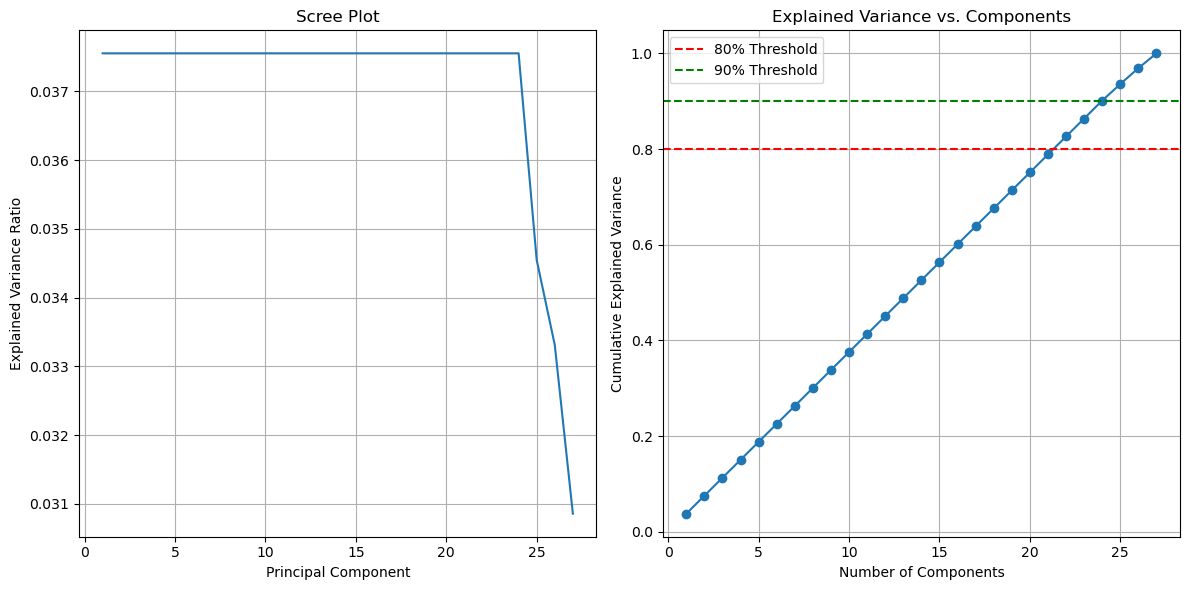

In [94]:
from sklearn.decomposition import PCA

ohc = OneHotEncoder(handle_unknown="ignore")
X_coded = ohc.fit_transform(X_train[categorical_cols])
pca = PCA(n_components=X_coded.shape[1] - 1, random_state=42)
pca_result = pca.fit_transform(X_coded)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)

# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Components")
plt.axhline(y=0.8, color="r", linestyle="--", label="80% Threshold")
plt.axhline(y=0.9, color="g", linestyle="--", label="90% Threshold")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [95]:
cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat_pipe", cat_pipe, categorical_cols),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())],
)

In [96]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sin_month', 'cos_month',
                                                   'Year', 'Month', 'num_days',
                                                   'holiday_num',
                                                   'crime_count_lag1',
                                                   'crime_pct_change_lag1',
                                                   'morning_lag1',
                                                   'afternoon_lag1',
                                                   'evening_lag1', 'night_lag1',
                                                   'crime_count_lag2',
                                                   'crime_pct_change_lag2',
                                                   'morning_lag2',
                                                   'afternoon_lag2',
                                                   'evening_lag2', 'nig...,
                                                   'crime_count_lag3',
                                                   'crime_pct_change_lag3',
                                                   'morning_lag3',
                                                   'afternoon_lag3',
                                                   'evening_lag3', 'night_lag3',
                                                   'crime_count_lag6',
                                                   'crime_pct_change_lag6',
                                                   'morning_lag6',
                                                   'afternoon_lag6',
                                                   'evening_lag6', 'night_lag6', ...]),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['location_name'])])),
                ('regressor', LinearRegression())])

In [97]:
lr_train_pred = model.predict(X_train)
lr_pred = model.predict(X_test)
lr_train_pred = np.round(lr_train_pred)
lr_pred = np.round(lr_pred)

In [98]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics
rmse = root_mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)
mean_value = y_test.mean()
print(mean_value)
mae_percentage = (mae / mean_value) * 100

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {mae_percentage:.2f}%")

665.7069892473119
Root Mean Squared Error: 182.24
Mean Absolute Error: 82.94
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 12.46%


# Random Forest Regressor


In [99]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [100]:
from sklearn.ensemble import RandomForestRegressor

# Same preprocessing pipeline, but switch out the regressor
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_pred = rf_model.predict(X_test)
rf_train_pred = np.round(rf_train_pred)
rf_pred = np.round(rf_pred)

In [101]:
# Evaluate the model
rf_rmse = root_mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae_percentage = (rf_mae / y_test.mean()) * 100

print(f"Random Forest Results:")
print(f"Root Mean Squared Error: {rf_rmse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {rf_mae_percentage:.2f}%")

Random Forest Results:
Root Mean Squared Error: 257.11
Mean Absolute Error: 84.20
R² Score: 0.98
Normalized Mean Absolute Error Percentage: 12.65%


In [102]:
from xgboost import XGBRegressor

xg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        (
            "regressor",
            XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=7,
                gamma=0.1,
                random_state=42,
            ),
        ),
    ]
)
xg_model.fit(X_train, y_train)
xg_train_pred = xg_model.predict(X_train)
xg_pred = xg_model.predict(X_test)
xg_train_pred = np.round(xg_train_pred)
xg_pred = np.round(xg_pred)

In [103]:
# Evaluate the model
xg_rmse = root_mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_r2 = r2_score(y_test, xg_pred)
xg_mae_percentage = (xg_mae / y_test.mean()) * 100
print(f"XGBoost Results:")
print(f"Root Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Error: {xg_mae:.2f}")
print(f"R² Score: {xg_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {xg_mae_percentage:.2f}%")

XGBoost Results:
Root Mean Squared Error: 341.60
Mean Absolute Error: 118.32
R² Score: 0.96
Normalized Mean Absolute Error Percentage: 17.77%


In [104]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    "regressor__n_estimators": [200],
    "regressor__learning_rate": [0.1],
    "regressor__max_depth": [5],
    "regressor__min_child_weight": [5],
    "regressor__gamma": [0.1],
}

# Create the pipeline with XGBRegressor
xg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=42))]
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Display progress
)

# Fit the grid search to the data
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best parameters: {best_params}")

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Testing metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing R²: {test_r2:.4f}")

# Store residuals for plotting
xg_res = y_test - y_test_pred

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid search completed!
Best parameters: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 200}

Model Performance:
Training RMSE: 13.6211
Training R²: 0.9999
Testing RMSE: 359.7743
Testing R²: 0.9577


In [105]:
df_test_result = df_test.copy()
# loading lstm and mlp results
df_lstm = pd.read_csv(data_path + "lstm_predictions_gen.csv")
df_mlp = pd.read_csv(data_path + "mlp_predictions_gen.csv")

df_test_result = df_test_result.merge(
    df_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)

df_test_result = df_test_result.merge(
    df_mlp[["location_id", "time_id", "mlp_pred"]],
    on=["location_id", "time_id"],
    how="left",
)

df_test_result["lr_pred"] = lr_pred
df_test_result["xg_pred"] = xg_pred
df_test_result["lstm_pred"] = df_test_result["lstm_pred"]
df_test_result["mlp_pred"] = df_test_result["mlp_pred"]
df_test_result

,Year,Month,location_id,location_name,crime_count,weekday,weekend,morning,afternoon,evening,...,night_rate_ma6,crime_count_ma6,morning_ma6,afternoon_ma6,evening_ma6,night_ma6,lstm_pred,mlp_pred,lr_pred,xg_pred
0,2023,1,1,Abandoned/Condemned Structure,25,19,6,9,6,1,...,0.264548,16.666667,3.666667,5.833333,2.166667,5.000000,14.0,29.0,28.0,16.0
1,2023,1,2,Air/Bus/Train Terminal,21,16,5,7,7,2,...,0.085751,16.166667,4.666667,8.833333,1.166667,1.500000,13.0,21.0,65.0,17.0
2,2023,1,4,Arena/Stadium/Fairgrounds/Coliseum,7,5,2,2,1,3,...,0.090224,15.666667,2.500000,6.166667,5.833333,1.166667,14.0,30.0,10.0,15.0
3,2023,1,5,ATM Separate from Bank,19,16,3,5,3,3,...,0.338624,10.666667,2.500000,2.666667,1.666667,3.833333,9.0,20.0,20.0,9.0
4,2023,1,6,Auto Dealership New/Used,73,57,16,21,27,7,...,0.302051,69.166667,22.000000,20.333333,6.000000,20.833333,65.0,92.0,93.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,2023,12,35,Residence/Home,8170,5601,2569,2102,2539,1814,...,0.219833,9540.000000,2506.333333,2746.500000,2184.500000,2102.666667,8802.0,8605.0,8130.0,7832.0
368,2023,12,37,Restaurant,282,197,85,64,103,71,...,0.187133,302.000000,67.000000,98.833333,79.500000,56.666667,273.0,269.0,239.0,260.0
369,2023,12,38,School/College,50,41,9,21,14,8,...,0.129674,79.166667,31.833333,26.333333,11.000000,10.000000,103.0,53.0,82.0,125.0
370,2023,12,41,Service/Gas Station,258,184,74,49,79,67,...,0.238773,289.500000,64.500000,81.166667,74.166667,69.666667,264.0,289.0,259.0,283.0


In [106]:
# summarize the results (metrics)
def summarize_results(df, model):
    rmse = root_mean_squared_error(df["crime_count"], df[model])
    mae = mean_absolute_error(df["crime_count"], df[model])
    r2 = r2_score(df["crime_count"], df[model])
    mean_value = df["crime_count"].mean()
    mae_percentage = (mae / mean_value) * 100
    return rmse, mae, r2, mae_percentage


for m in ["lr", "xg", "lstm", "mlp"]:
    rmse, mae, r2, mae_percentage = summarize_results(df_test_result, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
182.24	0.99	82.94	12.46%


Model: xg
RMSE	R²	MAE	MAE Percentage
341.60	0.96	118.32	17.77%


Model: lstm
RMSE	R²	MAE	MAE Percentage
143.80	0.99	51.10	7.68%


Model: mlp
RMSE	R²	MAE	MAE Percentage
148.51	0.99	68.41	10.28%




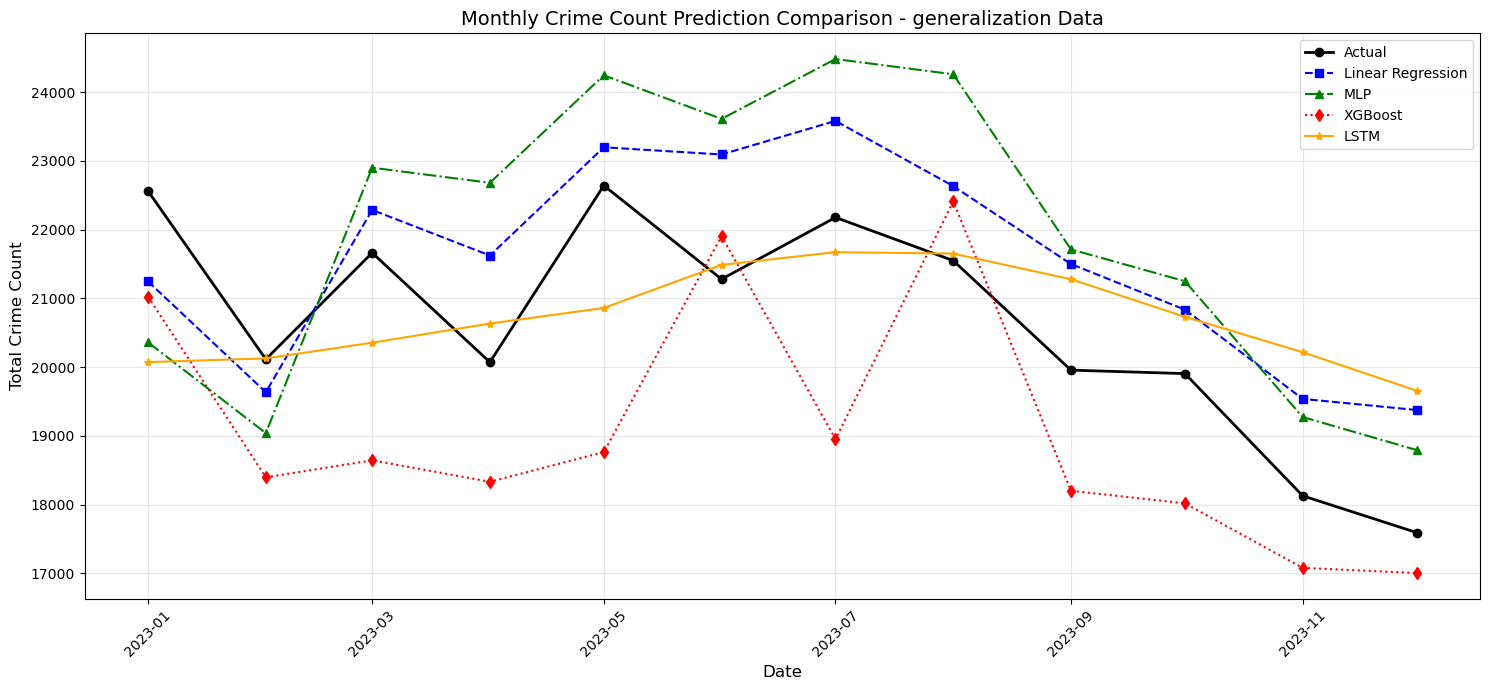

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. MONTHLY AGGREGATION PLOTS
# ============================

monthly_test = (
    df_test_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "mlp_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
        }
    )
    .reset_index()
)
monthly_test["date"] = pd.to_datetime(
    monthly_test["Year"].astype(str) + "-" + monthly_test["Month"].astype(str) + "-01"
)
monthly_test = monthly_test.sort_values("date")
y_test_monthly = monthly_test["crime_count"]
# Plot monthly comparison - Test data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_test["date"],
    monthly_test["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_test["date"],
    monthly_test["mlp_pred"],
    marker="^",
    linestyle="-.",
    label="MLP",
    color="green",
)
plt.plot(
    monthly_test["date"],
    monthly_test["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.title(
    "Monthly Crime Count Prediction Comparison - generalization Data", fontsize=14
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_gen_data.pdf", format="pdf")
plt.show()

In [108]:
for m in ["lr", "mlp", "xg", "lstm"]:
    rmse, mae, r2, mae_percentage = summarize_results(monthly_test, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
1288.50	0.33	1208.08	5.85%


Model: mlp
RMSE	R²	MAE	MAE Percentage
1885.71	-0.44	1793.75	8.69%


Model: xg
RMSE	R²	MAE	MAE Percentage
2084.17	-0.76	1823.83	8.84%


Model: lstm
RMSE	R²	MAE	MAE Percentage
1377.01	0.23	1105.67	5.36%




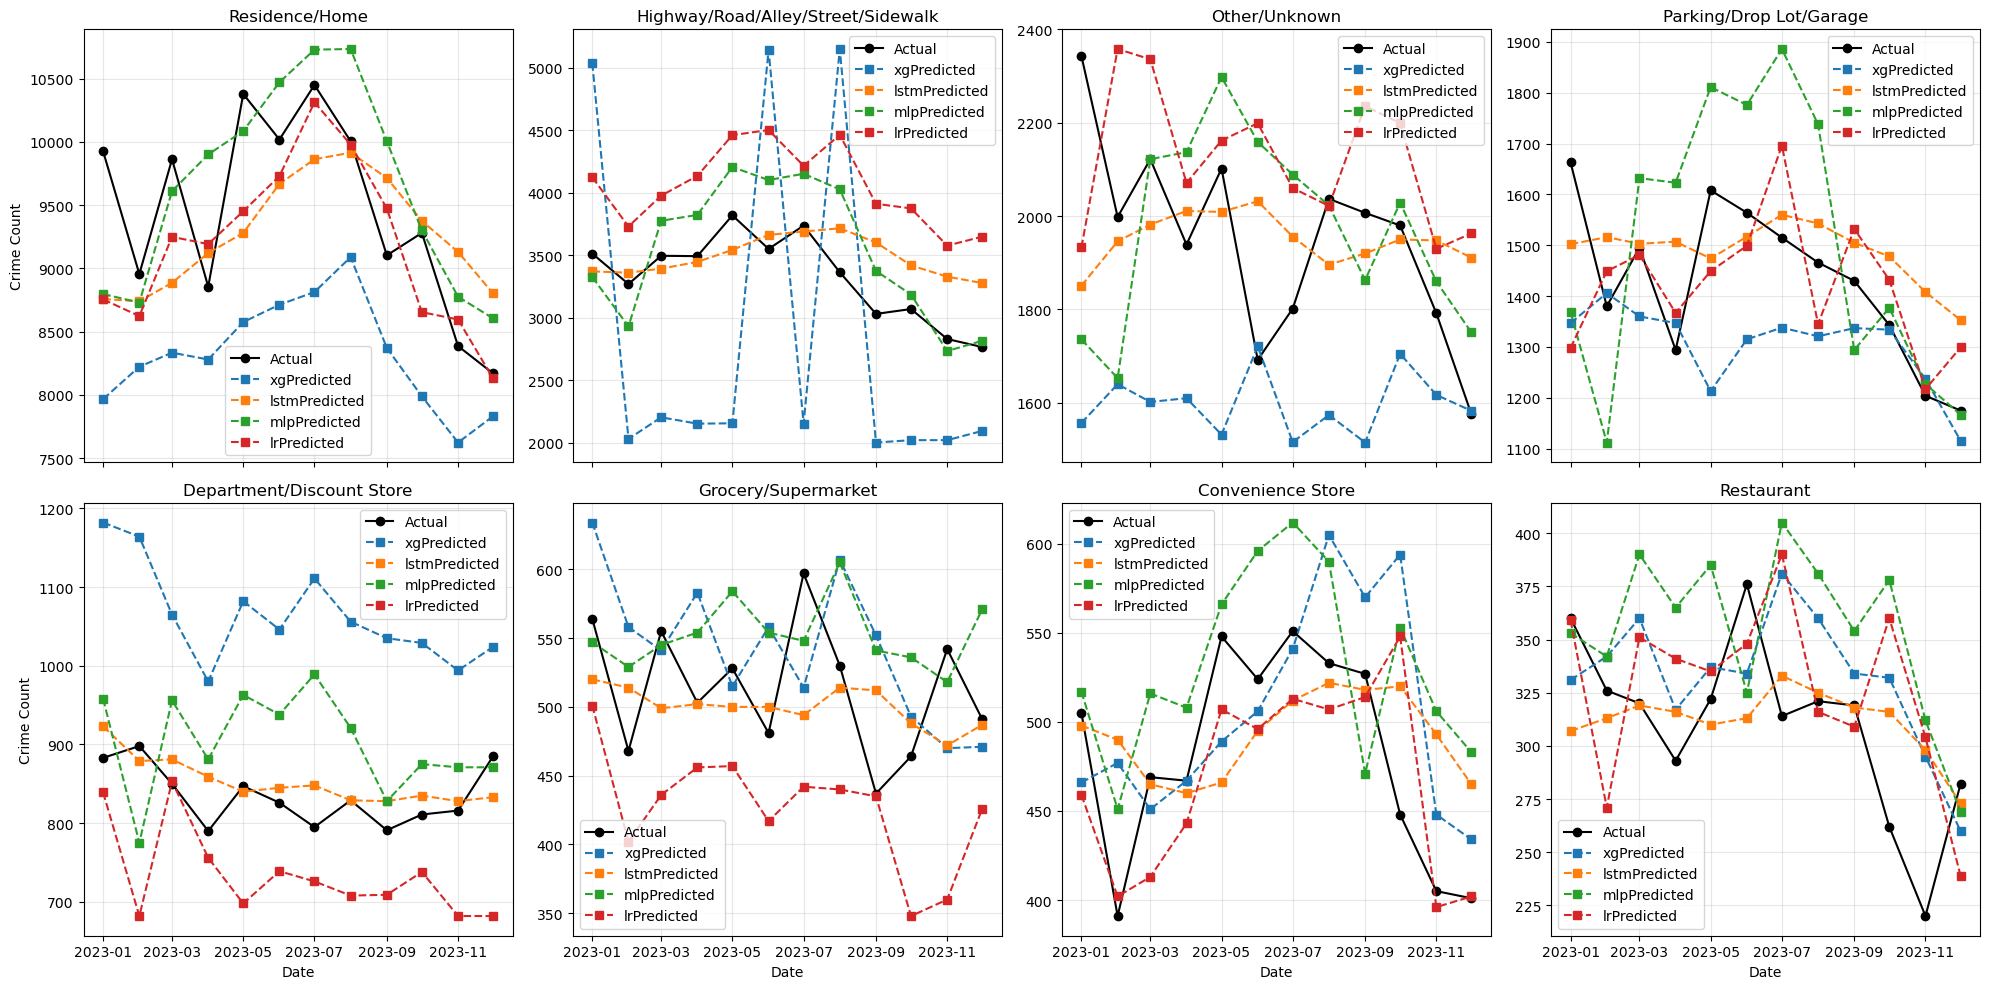

In [109]:
# 1. Identify the top 8 locations by total crime count
top8_locations = (
    df_test_result.groupby("location_name")["crime_count"]
    .sum()
    .nlargest(8)
    .index.tolist()
)

# 2. Filter data for these top 8 locations
df_top8 = df_test_result[df_test_result["location_name"].isin(top8_locations)].copy()

# 3. Aggregate monthly data (summing the actual and predicted counts)
df_trend = df_top8.groupby(["location_name", "Year", "Month"], as_index=False).agg(
    crime_count=("crime_count", "sum"),
    mlp_pred=("mlp_pred", "sum"),
    xg_pred=("xg_pred", "sum"),
    lr_pred=("lr_pred", "sum"),
    lstm_pred=("lstm_pred", "sum"),
)

# 4. Create a datetime column for proper time series plotting (using the 1st day of each month)
df_trend["Date"] = pd.to_datetime(
    df_trend["Year"].astype(str) + "-" + df_trend["Month"].astype(str) + "-01"
)

# 5. Plotting in subplots (2 rows x 4 columns for 8 subplots) without sharing the y-axis
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 10), sharex=True
)  # Remove sharey to allow independent y-axis
axes = axes.flatten()  # Flatten to iterate easily

for i, loc in enumerate(top8_locations):
    ax = axes[i]
    df_loc = df_trend[df_trend["location_name"] == loc].sort_values("Date")

    # Plot actual crime count
    ax.plot(
        df_loc["Date"],
        df_loc["crime_count"],
        marker="o",
        linestyle="-",
        label="Actual",
        color="black",
    )
    # Plot predicted crime count
    for m in ["xg", "lstm", "mlp", "lr"]:
        ax.plot(
            df_loc["Date"],
            df_loc[f"{m}_pred"],
            marker="s",
            linestyle="--",
            label=f"{m}Predicted",
        )

    ax.set_title(loc)
    ax.grid(True, alpha=0.3)

    # Set labels for the leftmost and bottom plots only
    if i % 4 == 0:  # Leftmost plots
        ax.set_ylabel("Crime Count")
    if i >= 4:  # Bottom row plots
        ax.set_xlabel("Date")

    ax.legend()

# Remove any unused subplots (if there are fewer than 8, not applicable here)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("./figure/monthly_crime_trends_top8_locations_gen_data.pdf", format="pdf")
plt.show()

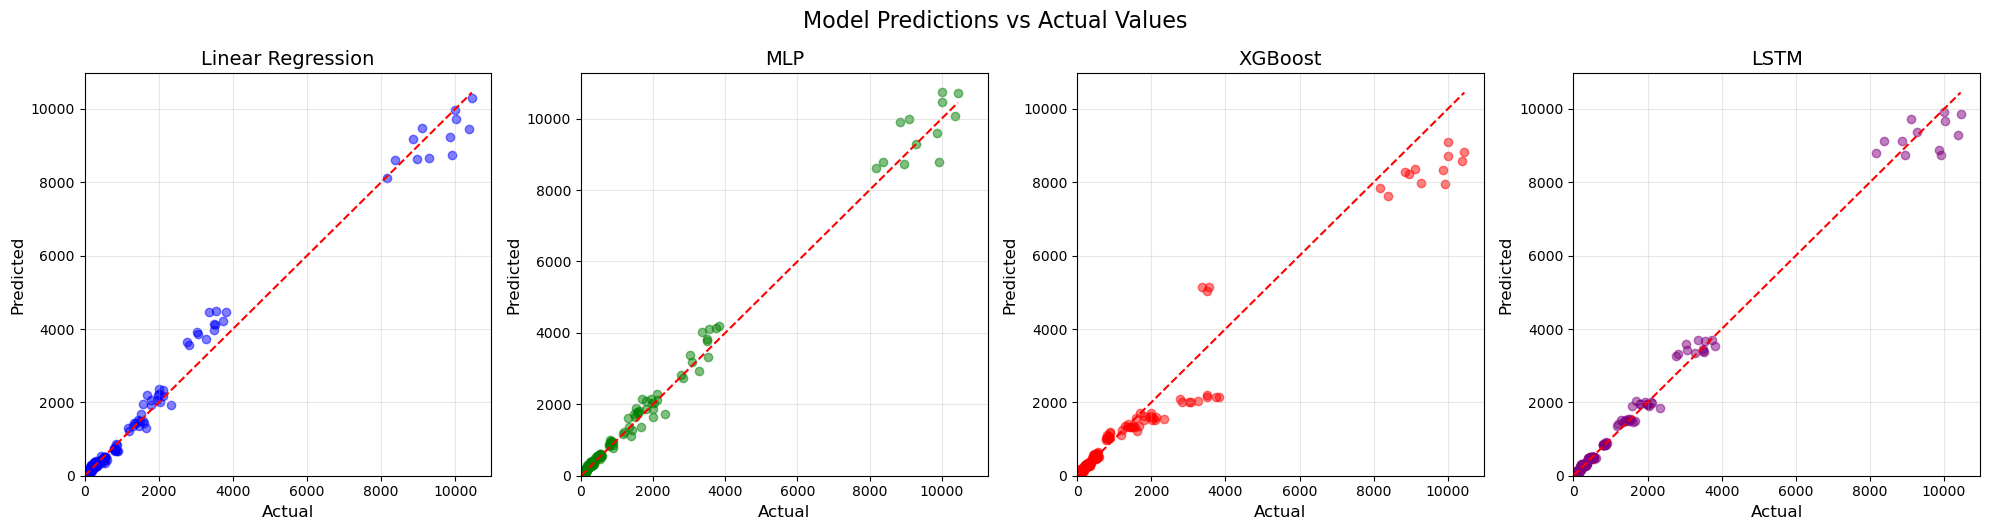

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 4 subplots (for LR, RF, XGBoost, and LSTM)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Define models, colors, and titles
models = ["lr_pred", "mlp_pred", "xg_pred", "lstm_pred"]
colors = ["blue", "green", "red", "purple"]
titles = ["Linear Regression", "MLP", "XGBoost", "LSTM"]

# Loop through each model and create scatter plot
for i, (model, color, title) in enumerate(zip(models, colors, titles)):
    # Create scatter plot
    axes[i].scatter(
        df_test_result["crime_count"], df_test_result[model], alpha=0.5, color=color
    )

    # Add diagonal line for perfect predictions
    axes[i].plot(
        [0, df_test_result["crime_count"].max()],
        [0, df_test_result["crime_count"].max()],
        "r--",
    )

    # Add title and labels
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Actual", fontsize=12)
    axes[i].set_ylabel("Predicted", fontsize=12)
    axes[i].grid(True, alpha=0.3)

    # Optional: Set the same limits for all plots for easier comparison
    max_val = max(df_test_result["crime_count"].max(), df_test_result[model].max())
    axes[i].set_xlim(0, max_val * 1.05)
    axes[i].set_ylim(0, max_val * 1.05)

# Adjust layout
plt.tight_layout()
plt.suptitle("Model Predictions vs Actual Values", fontsize=16, y=1.05)
plt.savefig("./figure/model_predictions_vs_actual_values_gen_data.pdf", format="pdf")
plt.show()